In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
df=pd.read_csv('got_scripts_breakdown.csv', sep=';')
df.head()

,Column1,Season,Episode,Sentence,Name,N_serie,N_Season,Emision Date
0,1,Season 1,winter is coming,What d’you expect? They’re savages One lot ste...,waymar royce,1,1,17/04/2011
1,2,Season 1,winter is coming,I’ve never seen wildlings do a thing like this...,will,1,1,17/04/2011
2,3,Season 1,winter is coming,How close did you get?,waymar royce,1,1,17/04/2011
3,4,Season 1,winter is coming,Close as any man would,will,1,1,17/04/2011
4,5,Season 1,winter is coming,We should head back to the wall,gared,1,1,17/04/2011


In [4]:
# Convert to list
data = df.Sentence.values.tolist()

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['what', 'you', 'expect', 'they', 're', 'savages', 'one', 'lot', 'steals', 'goat', 'from', 'another', 'lot', 'and', 'before', 'you', 'know', 'it', 'they', 're', 'ripping', 'each', 'other', 'to', 'pieces']]


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['what', 'you', 'expect', 'they', 're', 'savages', 'one', 'lot', 'steals', 'goat', 'from', 'another', 'lot', 'and', 'before', 'you', 'know', 'it', 'they', 're', 'ripping', 'each_other', 'to', 'pieces']


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['expect', 'savage', 'lot', 'steal', 'goat', 'lot', 'know', 'rip', 'piece']]


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [10]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('expect', 1),
  ('goat', 1),
  ('know', 1),
  ('lot', 2),
  ('piece', 1),
  ('rip', 1),
  ('savage', 1),
  ('steal', 1)]]

## Setting the number of topic (k value) as 20, let's try the model with eta (beta value) = 10, 1, 0.1, 0.01, 0.001 and  0.0001

### eta = 10

In [13]:
# Build LDA model
lda_model1 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta=10,
                                           per_word_topics=True)

In [14]:
pyLDAvis.enable_notebook()
vis1 = pyLDAvis.gensim.prepare(lda_model1, corpus, id2word)
vis1

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


TypeError: Object of type complex is not JSON serializable

PreparedData(topic_coordinates=                                x        y  topics  cluster       Freq
topic                                                                 
9        (0.16494003385305403+0j)       0j       1        1  99.922005
7       (-0.00868105441331865+0j)       0j       2        1   0.006701
17     (-0.008681054413318652+0j)       0j       3        1   0.006395
0      (-0.008681054413318652+0j)       0j       4        1   0.005537
10     (-0.008681054413318652+0j)       0j       5        1   0.005143
18      (-0.00868105441331864+0j)  (-0+0j)       6        1   0.004208
2       (-0.00868105441331864+0j)  (-0+0j)       7        1   0.003924
5       (-0.00868105441331864+0j)  (-0+0j)       8        1   0.003815
4       (-0.00868105441331864+0j)  (-0+0j)       9        1   0.003760
6       (-0.00868105441331864+0j)  (-0+0j)      10        1   0.003715
11      (-0.00868105441331864+0j)  (-0+0j)      11        1   0.003700
12      (-0.00868105441331864+0j)  (-0+0j)    

Getting an error message of "TypeError: Object of type complex is not JSON serializable"

### eta = 1

In [15]:
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta=1,
                                           per_word_topics=True)

In [16]:
pyLDAvis.enable_notebook()
vis2 = pyLDAvis.gensim.prepare(lda_model2, corpus, id2word)
vis2

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.345558  0.002724       1        1  85.551056
9      0.041746 -0.011515       2        1   6.353042
0      0.002572  0.001318       3        1   2.439713
2     -0.004224 -0.002699       4        1   1.822611
17    -0.007128 -0.004484       5        1   1.568090
8     -0.018246 -0.007201       6        1   0.664753
7     -0.020765 -0.005738       7        1   0.480338
13    -0.022068 -0.004493       8        1   0.388594
1     -0.024535 -0.001064       9        1   0.220653
5     -0.026411  0.002549      10        1   0.084260
15    -0.026425  0.002580      11        1   0.082834
4     -0.026562  0.002874      12        1   0.067680
11    -0.026573  0.002897      13        1   0.066304
3     -0.026649  0.003060      14        1   0.054699
6     -0.026692  0.003151      15        1   0.044953
19    -0.026704  0.003175      16        1   0.041011
18    -0.026721  0.003211      17        1   0.030614
12    -0.026724  0.003219      18        1   0.020401
16    -0.026724  0.003219      19        1   0.013838
14    -0.026724  0.003219      20        1   0.004557, topic_info=     Category         Freq           Term        Total  loglift  logprob
560   Default  2833.000000            not  2833.000000  30.0000   30.000
2     Default  1306.000000           know  1306.000000  29.0000   29.000
16    Default  1235.000000            man  1235.000000  28.0000   28.000
48    Default   872.000000             go   872.000000  27.0000   27.000
44    Default   865.000000           want   865.000000  26.0000   26.000
90    Default  1042.000000           come  1042.000000  25.0000   25.000
11    Default  1065.000000            see  1065.000000  24.0000   24.000
80    Default   621.000000           lord   621.000000  23.0000   23.000
29    Default   750.000000          think   750.000000  22.0000   22.000
15    Default   764.000000            get   764.000000  21.0000   21.000
49    Default   666.000000         father   666.000000  20.0000   20.000
151   Default   615.000000           take   615.000000  19.0000   19.000
40    Default   570.000000           good   570.000000  18.0000   18.000
42    Default   657.000000            say   657.000000  17.0000   17.000
53    Default  1741.000000             do  1741.000000  16.0000   16.000
414   Default   576.000000           make   576.000000  15.0000   15.000
91    Default   619.000000           tell   619.000000  14.0000   14.000
17    Default   585.000000          would   585.000000  13.0000   13.000
558   Default  1929.000000             be  1929.000000  12.0000   12.000
18    Default   657.000000           back   657.000000  11.0000   11.000
114   Default   516.000000           king   516.000000  10.0000   10.000
33    Default   575.000000           kill   575.000000   9.0000    9.000
10    Default   540.000000          never   540.000000   8.0000    8.000
102   Default   510.000000           need   510.000000   7.0000    7.000
210   Default   552.000000          queen   552.000000   6.0000    6.000
484   Default   507.000000          fight   507.000000   5.0000    5.000
116   Default   583.000000          north   583.000000   4.0000    4.000
12    Default   537.000000          thing   537.000000   3.0000    3.000
125   Default   518.000000            way   518.000000   2.0000    2.000
55    Default   459.000000           well   459.000000   1.0000    1.000
...       ...          ...            ...          ...      ...      ...
6994  Topic20     0.000834       annoying    72.813896  -1.3815   -8.853
2334  Topic20     0.000834          jafer     2.532717   1.9771   -8.853
2323  Topic20     0.000834      swordplay     2.535424   1.9760   -8.853
2324  Topic20     0.000834       braavosi     2.646973   1.9329   -8.853
2325  Topic20     0.000834           oafs     2.532716   1.9771   -8.853
2326  Topic20     0.000834       familiar     8.452818   0.7719   -8

### eta = 0.1

In [17]:
lda_model3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta=0.1,
                                           per_word_topics=True)

In [18]:
vis3 = pyLDAvis.gensim.prepare(lda_model3, corpus, id2word)
vis3

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.404949  0.135267       1        1  11.243542
2     -0.038719 -0.098997       2        1   6.684389
13    -0.103126  0.000285       3        1   6.650754
9     -0.050196 -0.327866       4        1   5.917061
8      0.011053 -0.006115       5        1   5.730512
1     -0.014604  0.032162       6        1   5.670712
3     -0.036335 -0.202610       7        1   5.661372
4      0.009016 -0.018148       8        1   5.551410
7      0.024001  0.006778       9        1   5.002186
17     0.032866  0.049804      10        1   4.936367
11     0.027633  0.031709      11        1   4.789360
12     0.009764  0.036934      12        1   4.604970
6      0.059829  0.041581      13        1   4.516101
0      0.030097  0.038697      14        1   4.468825
18     0.042553  0.040869      15        1   4.362448
19     0.055556  0.049264      16        1   3.949033
5      0.064884  0.038712      17        1   3.869788
15     0.089353  0.052572      18        1   2.694346
16     0.095273  0.049456      19        1   2.280141
14     0.096049  0.049646      20        1   1.416691, topic_info=     Category         Freq       Term        Total  loglift  logprob
560   Default  2966.000000        not  2966.000000  30.0000  30.0000
558   Default  2149.000000         be  2149.000000  29.0000  29.0000
53    Default  1823.000000         do  1823.000000  28.0000  28.0000
16    Default  1360.000000        man  1360.000000  27.0000  27.0000
2     Default  1322.000000       know  1322.000000  26.0000  26.0000
571   Default  1296.000000          s  1296.000000  25.0000  25.0000
90    Default  1076.000000       come  1076.000000  24.0000  24.0000
11    Default  1077.000000        see  1077.000000  23.0000  23.0000
48    Default  1040.000000         go  1040.000000  22.0000  22.0000
112   Default   990.000000       look   990.000000  21.0000  21.0000
44    Default  1018.000000       want  1018.000000  20.0000  20.0000
15    Default   912.000000        get   912.000000  19.0000  19.0000
679   Default   934.000000       have   934.000000  18.0000  18.0000
42    Default   713.000000        say   713.000000  17.0000  17.0000
80    Default   757.000000       lord   757.000000  16.0000  16.0000
91    Default   730.000000       tell   730.000000  15.0000  15.0000
29    Default   767.000000      think   767.000000  14.0000  14.0000
151   Default   667.000000       take   667.000000  13.0000  13.0000
18    Default   716.000000       back   716.000000  12.0000  12.0000
49    Default   785.000000     father   785.000000  11.0000  11.0000
714   Default   682.000000       walk   682.000000  10.0000  10.0000
33    Default   686.000000       kill   686.000000   9.0000   9.0000
414   Default   686.000000       make   686.000000   8.0000   8.0000
102   Default   622.000000       need   622.000000   7.0000   7.0000
116   Default   574.000000      north   574.000000   6.0000   6.0000
40    Default   561.000000       good   561.000000   5.0000   5.0000
12    Default   585.000000      thing   585.000000   4.0000   4.0000
72    Default   533.000000        jon   533.000000   3.0000   3.0000
10    Default   598.000000      never   598.000000   2.0000   2.0000
210   Default   543.000000      queen   543.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
1072  Topic20   107.245949       crow   108.860252   4.2419  -2.8274
598   Topic20    97.192528    already    98.802650   4.2404  -2.9258
0     Topic20    70.626953     expect    72.237007   4.2343  -3.2451
3     Topic20    70.011063        lot    71.621124   4.2341  -3.2539
93    Topic20    69.627167      young    71.237267   4.2340  -3.2594
104   Topic20    64.442787      sorry    66.052750   4.2322  -3.3367
903   Topic20    44.272327    quickly    45.883236   4.2211  -3.7122
305   Topic20    43.356407     clever    44.966686   4.2204  -3.7331
7     Top

### eta = 0.01

In [19]:
lda_model4 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta=0.01,
                                           per_word_topics=True)

In [20]:
vis4 = pyLDAvis.gensim.prepare(lda_model4, corpus, id2word)
vis4

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10     0.218304  0.399037       1        1  9.675624
17     0.117065 -0.131987       2        1  8.469132
2      0.136385 -0.199416       3        1  8.096936
4      0.073434 -0.044131       4        1  6.735445
8      0.057840 -0.029756       5        1  6.364116
1      0.093822 -0.071199       6        1  5.939818
11    -0.009730  0.006271       7        1  5.908468
12     0.041751 -0.017573       8        1  5.877652
9      0.064354 -0.035139       9        1  5.407224
0     -0.009410  0.006357      10        1  4.975196
18     0.050706 -0.024139      11        1  4.702618
3      0.067802 -0.038456      12        1  4.627957
5      0.007619 -0.000365      13        1  4.381563
7     -0.020900  0.009406      14        1  4.358469
6     -0.104541  0.025406      15        1  3.554169
13    -0.129971  0.028329      16        1  2.939251
19    -0.120869  0.027338      17        1  2.548871
15    -0.144375  0.029536      18        1  2.408880
16    -0.191114  0.030902      19        1  1.997501
14    -0.198172  0.029580      20        1  1.031102, topic_info=     Category         Freq           Term       Total  loglift  logprob
53    Default  5218.000000             do  5218.00000  30.0000  30.0000
16    Default  4130.000000            man  4130.00000  29.0000  29.0000
2     Default  4328.000000           know  4328.00000  28.0000  28.0000
90    Default  3328.000000           come  3328.00000  27.0000  27.0000
11    Default  2929.000000            see  2929.00000  26.0000  26.0000
48    Default  2943.000000             go  2943.00000  25.0000  25.0000
91    Default  2269.000000           tell  2269.00000  24.0000  24.0000
44    Default  2863.000000           want  2863.00000  23.0000  23.0000
15    Default  2579.000000            get  2579.00000  22.0000  22.0000
112   Default  2288.000000           look  2288.00000  21.0000  21.0000
42    Default  1890.000000            say  1890.00000  20.0000  20.0000
18    Default  1978.000000           back  1978.00000  19.0000  19.0000
49    Default  2206.000000         father  2206.00000  18.0000  18.0000
29    Default  1772.000000          think  1772.00000  17.0000  17.0000
80    Default  2169.000000           lord  2169.00000  16.0000  16.0000
33    Default  1940.000000           kill  1940.00000  15.0000  15.0000
151   Default  1667.000000           take  1667.00000  14.0000  14.0000
125   Default  1672.000000            way  1672.00000  13.0000  13.0000
114   Default  1723.000000           king  1723.00000  12.0000  12.0000
116   Default  1474.000000          north  1474.00000  11.0000  11.0000
31    Default  1250.000000          could  1250.00000  10.0000  10.0000
40    Default  1441.000000           good  1441.00000   9.0000   9.0000
102   Default  1781.000000           need  1781.00000   8.0000   8.0000
148   Default  1301.000000           give  1301.00000   7.0000   7.0000
210   Default  1395.000000          queen  1395.00000   6.0000   6.0000
161   Default  1071.000000        brother  1071.00000   5.0000   5.0000
10    Default  1485.000000          never  1485.00000   4.0000   4.0000
12    Default  1476.000000          thing  1476.00000   3.0000   3.0000
72    Default  1329.000000            jon  1329.00000   2.0000   2.0000
17    Default  1750.000000          would  1750.00000   1.0000   1.0000
...       ...          ...            ...         ...      ...      ...
2439  Topic20     0.023972        scruple     0.49577   1.5453 -10.9157
2455  Topic20     0.023972      surprised     0.49577   1.5453 -10.9157
2456  Topic20     0.023972    walder_frey     0.49577   1.5453 -10.9157
2457  Topic20     0.023972         marche     0.49577   1.5453 -10.9157
2458  Topic20     0.023972       crossing     0.49577   1.5453 -10.9157
2459  Topic20     0.023972          exact     0.49577   1.5453 -10.9157
2460  Topic20     0.023972           toll     0.49577  

### eta = 0.001

In [21]:
lda_model5 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta=0.001,
                                           per_word_topics=True)

In [22]:
vis5 = pyLDAvis.gensim.prepare(lda_model5, corpus, id2word)
vis5

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10     0.199050 -0.412630       1        1  9.588953
17     0.109714  0.119026       2        1  8.477919
2      0.131675  0.196804       3        1  8.104165
4      0.074107  0.044665       4        1  6.743244
8      0.061230  0.032112       5        1  6.370377
1      0.092865  0.071274       6        1  5.945012
11    -0.005511 -0.004681       7        1  5.914415
12     0.043506  0.018274       8        1  5.883373
9      0.065529  0.036126       9        1  5.411960
0     -0.005623 -0.004964      10        1  4.979765
18     0.053731  0.026038      11        1  4.707150
3      0.070102  0.040498      12        1  4.632394
5      0.012109  0.002245      13        1  4.385535
7     -0.015452 -0.007263      14        1  4.362957
6     -0.099354 -0.022920      15        1  3.557524
13    -0.127196 -0.026090      16        1  2.941998
19    -0.117031 -0.024979      17        1  2.550916
15    -0.143092 -0.027376      18        1  2.411117
16    -0.196531 -0.028872      19        1  1.999310
14    -0.203827 -0.027286      20        1  1.031914, topic_info=     Category         Freq           Term        Total  loglift  logprob
53    Default  5267.000000             do  5267.000000  30.0000  30.0000
16    Default  4214.000000            man  4214.000000  29.0000  29.0000
2     Default  4401.000000           know  4401.000000  28.0000  28.0000
90    Default  3402.000000           come  3402.000000  27.0000  27.0000
11    Default  2989.000000            see  2989.000000  26.0000  26.0000
48    Default  3006.000000             go  3006.000000  25.0000  25.0000
91    Default  2364.000000           tell  2364.000000  24.0000  24.0000
44    Default  2911.000000           want  2911.000000  23.0000  23.0000
15    Default  2634.000000            get  2634.000000  22.0000  22.0000
42    Default  1976.000000            say  1976.000000  21.0000  21.0000
112   Default  2336.000000           look  2336.000000  20.0000  20.0000
18    Default  2034.000000           back  2034.000000  19.0000  19.0000
49    Default  2242.000000         father  2242.000000  18.0000  18.0000
29    Default  1809.000000          think  1809.000000  17.0000  17.0000
33    Default  1982.000000           kill  1982.000000  16.0000  16.0000
80    Default  2205.000000           lord  2205.000000  15.0000  15.0000
151   Default  1708.000000           take  1708.000000  14.0000  14.0000
125   Default  1715.000000            way  1715.000000  13.0000  13.0000
114   Default  1758.000000           king  1758.000000  12.0000  12.0000
31    Default  1311.000000          could  1311.000000  11.0000  11.0000
116   Default  1506.000000          north  1506.000000  10.0000  10.0000
161   Default  1172.000000        brother  1172.000000   9.0000   9.0000
148   Default  1356.000000           give  1356.000000   8.0000   8.0000
40    Default  1472.000000           good  1472.000000   7.0000   7.0000
102   Default  1811.000000           need  1811.000000   6.0000   6.0000
210   Default  1426.000000          queen  1426.000000   5.0000   5.0000
10    Default  1513.000000          never  1513.000000   4.0000   4.0000
72    Default  1363.000000            jon  1363.000000   3.0000   3.0000
12    Default  1503.000000          thing  1503.000000   2.0000   2.0000
17    Default  1767.000000          would  1767.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
2438  Topic20     0.002709           role     0.051416   1.6304 -13.0968
2454  Topic20     0.002709       movement     0.051416   1.6304 -13.0968
2455  Topic20     0.002709      surprised     0.051416   1.6304 -13.0968
2456  Topic20     0.002709    walder_frey     0.051416   1.6304 -13.0968
2457  Topic20     0.002709         marche     0.051416   1.6304 -13.0968
2458  Topic20     0.002709       crossing     0.051416   1.6304 -13.0968
2459  Topic20    

### eta = 0.0001

In [23]:
lda_model6 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta=0.0001,
                                           per_word_topics=True)

/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


In [24]:
vis6 = pyLDAvis.gensim.prepare(lda_model6, corpus, id2word)
vis6

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10     0.197785  0.414655       1        1  9.588957
17     0.106623 -0.112569       2        1  8.477921
2      0.132570 -0.196180       3        1  8.104165
4      0.074437 -0.044906       4        1  6.743242
8      0.062752 -0.036429       5        1  6.370376
1      0.093411 -0.071718       6        1  5.945010
11    -0.006540  0.004575       7        1  5.914414
12     0.042272 -0.018354       8        1  5.883373
9      0.065333 -0.036368       9        1  5.411959
0     -0.007066  0.005517      10        1  4.979765
18     0.054482 -0.029292      11        1  4.707151
3      0.071371 -0.041516      12        1  4.632395
5      0.011858 -0.003607      13        1  4.385536
7     -0.015735  0.007896      14        1  4.362957
6     -0.098189  0.022954      15        1  3.557526
13    -0.126608  0.026143      16        1  2.941998
19    -0.116217  0.024999      17        1  2.550918
15    -0.142611  0.027410      18        1  2.411117
16    -0.196449  0.029173      19        1  1.999310
14    -0.203480  0.027615      20        1  1.031914, topic_info=     Category         Freq           Term        Total  loglift  logprob
53    Default  5274.000000             do  5274.000000  30.0000  30.0000
16    Default  4222.000000            man  4222.000000  29.0000  29.0000
2     Default  4407.000000           know  4407.000000  28.0000  28.0000
90    Default  3409.000000           come  3409.000000  27.0000  27.0000
11    Default  2995.000000            see  2995.000000  26.0000  26.0000
48    Default  3012.000000             go  3012.000000  25.0000  25.0000
91    Default  2374.000000           tell  2374.000000  24.0000  24.0000
44    Default  2916.000000           want  2916.000000  23.0000  23.0000
42    Default  1985.000000            say  1985.000000  22.0000  22.0000
15    Default  2640.000000            get  2640.000000  21.0000  21.0000
112   Default  2340.000000           look  2340.000000  20.0000  20.0000
18    Default  2039.000000           back  2039.000000  19.0000  19.0000
49    Default  2246.000000         father  2246.000000  18.0000  18.0000
29    Default  1812.000000          think  1812.000000  17.0000  17.0000
33    Default  1986.000000           kill  1986.000000  16.0000  16.0000
80    Default  2209.000000           lord  2209.000000  15.0000  15.0000
151   Default  1713.000000           take  1713.000000  14.0000  14.0000
125   Default  1720.000000            way  1720.000000  13.0000  13.0000
114   Default  1761.000000           king  1761.000000  12.0000  12.0000
31    Default  1317.000000          could  1317.000000  11.0000  11.0000
161   Default  1183.000000        brother  1183.000000  10.0000  10.0000
116   Default  1509.000000          north  1509.000000   9.0000   9.0000
148   Default  1361.000000           give  1361.000000   8.0000   8.0000
40    Default  1475.000000           good  1475.000000   7.0000   7.0000
102   Default  1814.000000           need  1814.000000   6.0000   6.0000
210   Default  1428.000000          queen  1428.000000   5.0000   5.0000
10    Default  1515.000000          never  1515.000000   4.0000   4.0000
72    Default  1366.000000            jon  1366.000000   3.0000   3.0000
12    Default  1506.000000          thing  1506.000000   2.0000   2.0000
17    Default  1769.000000          would  1769.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
2438  Topic20     0.000274           role     0.005161   1.6396 -15.3864
2454  Topic20     0.000274       movement     0.005161   1.6396 -15.3864
2455  Topic20     0.000274      surprised     0.005161   1.6396 -15.3864
2456  Topic20     0.000274    walder_frey     0.005161   1.6396 -15.3864
2457  Topic20     0.000274         marche     0.005161   1.6396 -15.3864
2458  Topic20     0.000274       crossing     0.005161   1.6396 -15.3864
2459  Topic20    

### Based on the graphs above, it seems like the topics are more spread out when eat = 0.1
#### It is also interesting to note that the graphs for eta = 0.001 and eta = 0.0001 are mirror image of each other

### Now let's take a look at the topics and associated words when eta = 0.1

In [25]:
# Print the Keyword in the 20 topics
pprint(lda_model3.print_topics())
doc_lda = lda_model3[corpus]

[(0,
  '0.095*"way" + 0.076*"stand" + 0.051*"murder" + 0.046*"fuck" + 0.045*"try" + '
  '0.043*"child" + 0.039*"mean" + 0.031*"city" + 0.029*"pull" + '
  '0.023*"choose"'),
 (1,
  '0.082*"never" + 0.058*"hand" + 0.057*"ever" + 0.051*"cersei" + 0.045*"war" '
  '+ 0.041*"head" + 0.039*"world" + 0.031*"talk" + 0.027*"life" + '
  '0.023*"stay"'),
 (2,
  '0.119*"want" + 0.092*"father" + 0.070*"fight" + 0.053*"dragon" + '
  '0.052*"army" + 0.034*"let" + 0.023*"home" + 0.022*"gold" + 0.021*"nice" + '
  '0.020*"hold"'),
 (3,
  '0.179*"s" + 0.137*"look" + 0.106*"think" + 0.059*"right" + 0.050*"die" + '
  '0.033*"face" + 0.032*"happen" + 0.031*"line" + 0.030*"ask" + 0.023*"bran"'),
 (4,
  '0.191*"man" + 0.080*"king" + 0.069*"arya" + 0.042*"sansa" + 0.040*"great" + '
  '0.040*"help" + 0.035*"sister" + 0.028*"betray" + 0.018*"open" + '
  '0.018*"castle"'),
 (5,
  '0.135*"take" + 0.107*"jon" + 0.059*"love" + 0.033*"anything" + '
  '0.031*"enough" + 0.030*"tree" + 0.028*"else" + 0.026*"kings_lande" 

In [26]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.578037494869359

Coherence Score:  0.5437313382396713


### Since we still most of the topics overlapping each other when k = 20 and eta = 0.1, let's try eta = 0.01, 0.001, and 0.0001 when different k values to find out if the ideal coherence score changes with the eta value

#### eta = 0.1

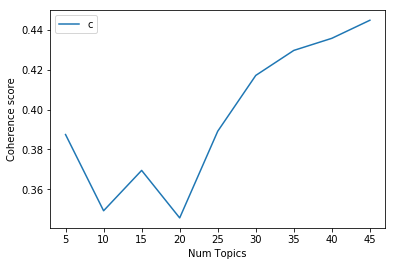

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta=0.1,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=50, step=5)


# Show graph
limit=50; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [17]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.3874
Num Topics = 10  has Coherence Value of 0.3492
Num Topics = 15  has Coherence Value of 0.3694
Num Topics = 20  has Coherence Value of 0.3456
Num Topics = 25  has Coherence Value of 0.3891
Num Topics = 30  has Coherence Value of 0.4172
Num Topics = 35  has Coherence Value of 0.4297
Num Topics = 40  has Coherence Value of 0.4358
Num Topics = 45  has Coherence Value of 0.4449


#### Here we can see that k = 20 is the elbow point, let's take a look at the words this model gives us

In [19]:
# Select the model and print the topics
optimal_model = model_list[3] 
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.095*"way" + 0.076*"stand" + 0.051*"murder" + 0.046*"fuck" + 0.045*"try" + '
  '0.043*"child" + 0.039*"mean" + 0.031*"city" + 0.029*"pull" + '
  '0.023*"choose"'),
 (1,
  '0.082*"never" + 0.058*"hand" + 0.057*"ever" + 0.051*"cersei" + 0.045*"war" '
  '+ 0.041*"head" + 0.039*"world" + 0.031*"talk" + 0.027*"life" + '
  '0.023*"stay"'),
 (2,
  '0.119*"want" + 0.092*"father" + 0.070*"fight" + 0.053*"dragon" + '
  '0.052*"army" + 0.034*"let" + 0.023*"home" + 0.022*"gold" + 0.021*"nice" + '
  '0.020*"hold"'),
 (3,
  '0.179*"s" + 0.137*"look" + 0.106*"think" + 0.059*"right" + 0.050*"die" + '
  '0.033*"face" + 0.032*"happen" + 0.031*"line" + 0.030*"ask" + 0.023*"bran"'),
 (4,
  '0.191*"man" + 0.080*"king" + 0.069*"arya" + 0.042*"sansa" + 0.040*"great" + '
  '0.040*"help" + 0.035*"sister" + 0.028*"betray" + 0.018*"open" + '
  '0.018*"castle"'),
 (5,
  '0.135*"take" + 0.107*"jon" + 0.059*"love" + 0.033*"anything" + '
  '0.031*"enough" + 0.030*"tree" + 0.028*"else" + 0.026*"kings_lande" 

#### eta = 0.01

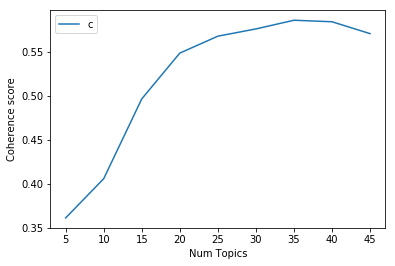

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta=0.01,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=50, step=5)

limit=50; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.3611
Num Topics = 10  has Coherence Value of 0.4058
Num Topics = 15  has Coherence Value of 0.4966
Num Topics = 20  has Coherence Value of 0.5487
Num Topics = 25  has Coherence Value of 0.568
Num Topics = 30  has Coherence Value of 0.5762
Num Topics = 35  has Coherence Value of 0.5861
Num Topics = 40  has Coherence Value of 0.5844
Num Topics = 45  has Coherence Value of 0.5709


#### elbow point at k = 10

In [22]:
# Select the model and print the topics
optimal_model = model_list[1] 
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.142*"would" + 0.126*"way" + 0.126*"king" + 0.092*"hand" + 0.065*"head" + '
  '0.061*"fuck" + 0.044*"life" + 0.043*"winter" + 0.041*"city" + '
  '0.037*"anything"'),
 (1,
  '0.329*"dead" + 0.143*"mother" + 0.114*"bran" + 0.096*"much" + 0.078*"year" '
  '+ 0.070*"seem" + 0.043*"move" + 0.040*"white_walker" + 0.038*"thousand" + '
  '0.010*"frighten"'),
 (2,
  '0.185*"get" + 0.162*"father" + 0.159*"back" + 0.149*"take" + 0.079*"run" + '
  '0.040*"thank" + 0.033*"true" + 0.027*"close" + 0.026*"horse" + 0.023*"lie"'),
 (3,
  '0.150*"look" + 0.134*"want" + 0.096*"lord" + 0.089*"kill" + 0.079*"need" + '
  '0.049*"lady" + 0.044*"stark" + 0.043*"watch" + 0.042*"away" + '
  '0.039*"tyrion"'),
 (4,
  '0.323*"man" + 0.279*"see" + 0.228*"go" + 0.080*"sword" + 0.028*"someone" + '
  '0.025*"mountain" + 0.012*"pass" + 0.010*"swing" + 0.000*"entertainment" + '
  '0.000*"population"'),
 (5,
  '0.196*"think" + 0.153*"north" + 0.093*"die" + 0.093*"long" + '
  '0.081*"winterfell" + 0.069*"house" +

#### eta = 0.001

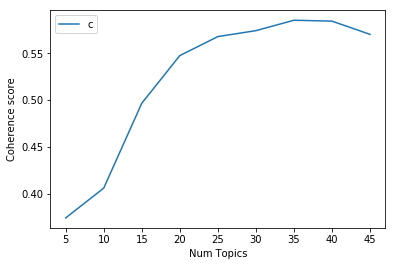

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta=0.001,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=50, step=5)

limit=50; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.3739
Num Topics = 10  has Coherence Value of 0.4058
Num Topics = 15  has Coherence Value of 0.4966
Num Topics = 20  has Coherence Value of 0.5476
Num Topics = 25  has Coherence Value of 0.568
Num Topics = 30  has Coherence Value of 0.5743
Num Topics = 35  has Coherence Value of 0.5855
Num Topics = 40  has Coherence Value of 0.5845
Num Topics = 45  has Coherence Value of 0.5704


#### elbow point at k = 10

In [25]:
# Select the model and print the topics
optimal_model = model_list[1] 
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.144*"would" + 0.128*"way" + 0.127*"king" + 0.093*"hand" + 0.066*"head" + '
  '0.062*"fuck" + 0.044*"life" + 0.043*"winter" + 0.041*"city" + '
  '0.037*"anything"'),
 (1,
  '0.341*"dead" + 0.148*"mother" + 0.118*"bran" + 0.100*"much" + 0.081*"year" '
  '+ 0.072*"seem" + 0.045*"move" + 0.042*"white_walker" + 0.039*"thousand" + '
  '0.010*"frighten"'),
 (2,
  '0.188*"get" + 0.164*"father" + 0.161*"back" + 0.151*"take" + 0.080*"run" + '
  '0.040*"thank" + 0.033*"true" + 0.027*"close" + 0.027*"horse" + 0.023*"lie"'),
 (3,
  '0.151*"look" + 0.135*"want" + 0.097*"lord" + 0.090*"kill" + 0.080*"need" + '
  '0.049*"lady" + 0.044*"stark" + 0.043*"watch" + 0.043*"away" + '
  '0.040*"tyrion"'),
 (4,
  '0.328*"man" + 0.283*"see" + 0.231*"go" + 0.081*"sword" + 0.028*"someone" + '
  '0.025*"mountain" + 0.013*"pass" + 0.010*"swing" + 0.000*"entertainment" + '
  '0.000*"population"'),
 (5,
  '0.199*"think" + 0.155*"north" + 0.095*"die" + 0.094*"long" + '
  '0.082*"winterfell" + 0.070*"house" +

#### eta = 0.0001

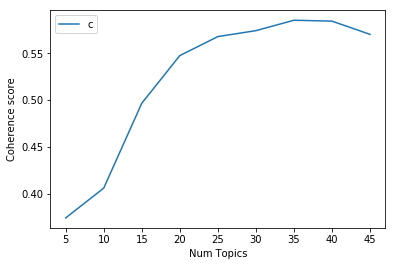

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta=0.0001,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=50, step=5)

limit=50; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.3739
Num Topics = 10  has Coherence Value of 0.4058
Num Topics = 15  has Coherence Value of 0.4966
Num Topics = 20  has Coherence Value of 0.5476
Num Topics = 25  has Coherence Value of 0.568
Num Topics = 30  has Coherence Value of 0.5743
Num Topics = 35  has Coherence Value of 0.5855
Num Topics = 40  has Coherence Value of 0.5845
Num Topics = 45  has Coherence Value of 0.5704


In [30]:
# Select the model and print the topics
optimal_model = model_list[1] 
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.144*"would" + 0.128*"way" + 0.127*"king" + 0.093*"hand" + 0.066*"head" + '
  '0.062*"fuck" + 0.045*"life" + 0.043*"winter" + 0.041*"city" + '
  '0.037*"anything"'),
 (1,
  '0.342*"dead" + 0.149*"mother" + 0.119*"bran" + 0.100*"much" + 0.081*"year" '
  '+ 0.073*"seem" + 0.045*"move" + 0.042*"white_walker" + 0.039*"thousand" + '
  '0.010*"frighten"'),
 (2,
  '0.188*"get" + 0.164*"father" + 0.161*"back" + 0.151*"take" + 0.080*"run" + '
  '0.040*"thank" + 0.033*"true" + 0.027*"close" + 0.027*"horse" + 0.023*"lie"'),
 (3,
  '0.151*"look" + 0.135*"want" + 0.097*"lord" + 0.090*"kill" + 0.080*"need" + '
  '0.049*"lady" + 0.044*"stark" + 0.043*"watch" + 0.043*"away" + '
  '0.040*"tyrion"'),
 (4,
  '0.328*"man" + 0.283*"see" + 0.232*"go" + 0.081*"sword" + 0.028*"someone" + '
  '0.025*"mountain" + 0.013*"pass" + 0.010*"swing" + 0.000*"entertainment" + '
  '0.000*"population"'),
 (5,
  '0.199*"think" + 0.155*"north" + 0.095*"die" + 0.094*"long" + '
  '0.083*"winterfell" + 0.070*"house" +

### Now let's try to visualize the topics with different eta values and their coresponding optimal k values

#### eta = 0.1, k = 20

In [11]:
optimal_model1 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta=0.1,
                                           per_word_topics=True)

In [16]:
pyLDAvis.enable_notebook()
vis_opt1 = pyLDAvis.gensim.prepare(optimal_model1, corpus, id2word)
vis_opt1 

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.404949  0.135267       1        1  11.243546
2     -0.038719 -0.098997       2        1   6.684388
13    -0.103126  0.000285       3        1   6.650754
9     -0.050196 -0.327866       4        1   5.917058
8      0.011053 -0.006115       5        1   5.730512
1     -0.014604  0.032162       6        1   5.670709
3     -0.036335 -0.202610       7        1   5.661368
4      0.009016 -0.018148       8        1   5.551409
7      0.024001  0.006778       9        1   5.002182
17     0.032866  0.049804      10        1   4.936364
11     0.027633  0.031709      11        1   4.789358
12     0.009764  0.036934      12        1   4.604967
6      0.059829  0.041581      13        1   4.516101
0      0.030097  0.038697      14        1   4.468826
18     0.042553  0.040869      15        1   4.362447
19     0.055556  0.049264      16        1   3.949033
5      0.064884  0.038712      17        1   3.869791
15     0.089353  0.052572      18        1   2.694344
16     0.095273  0.049456      19        1   2.280145
14     0.096049  0.049646      20        1   1.416691, topic_info=     Category         Freq       Term        Total  loglift  logprob
560   Default  2966.000000        not  2966.000000  30.0000  30.0000
558   Default  2149.000000         be  2149.000000  29.0000  29.0000
53    Default  1823.000000         do  1823.000000  28.0000  28.0000
16    Default  1360.000000        man  1360.000000  27.0000  27.0000
2     Default  1322.000000       know  1322.000000  26.0000  26.0000
571   Default  1296.000000          s  1296.000000  25.0000  25.0000
90    Default  1076.000000       come  1076.000000  24.0000  24.0000
11    Default  1077.000000        see  1077.000000  23.0000  23.0000
48    Default  1040.000000         go  1040.000000  22.0000  22.0000
112   Default   990.000000       look   990.000000  21.0000  21.0000
44    Default  1018.000000       want  1018.000000  20.0000  20.0000
15    Default   912.000000        get   912.000000  19.0000  19.0000
679   Default   934.000000       have   934.000000  18.0000  18.0000
42    Default   713.000000        say   713.000000  17.0000  17.0000
80    Default   757.000000       lord   757.000000  16.0000  16.0000
91    Default   730.000000       tell   730.000000  15.0000  15.0000
29    Default   767.000000      think   767.000000  14.0000  14.0000
151   Default   667.000000       take   667.000000  13.0000  13.0000
18    Default   716.000000       back   716.000000  12.0000  12.0000
49    Default   785.000000     father   785.000000  11.0000  11.0000
714   Default   682.000000       walk   682.000000  10.0000  10.0000
33    Default   686.000000       kill   686.000000   9.0000   9.0000
414   Default   686.000000       make   686.000000   8.0000   8.0000
102   Default   622.000000       need   622.000000   7.0000   7.0000
116   Default   574.000000      north   574.000000   6.0000   6.0000
40    Default   561.000000       good   561.000000   5.0000   5.0000
12    Default   585.000000      thing   585.000000   4.0000   4.0000
72    Default   533.000000        jon   533.000000   3.0000   3.0000
10    Default   598.000000      never   598.000000   2.0000   2.0000
210   Default   543.000000      queen   543.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
1072  Topic20   107.245964       crow   108.860268   4.2419  -2.8274
598   Topic20    97.192543    already    98.802666   4.2404  -2.9258
0     Topic20    70.626961     expect    72.237015   4.2343  -3.2451
3     Topic20    70.011070        lot    71.621132   4.2341  -3.2539
93    Topic20    69.627174      young    71.237274   4.2340  -3.2594
104   Topic20    64.442795      sorry    66.052757   4.2322  -3.3367
903   Topic20    44.272335    quickly    45.883244   4.2211  -3.7122
305   Topic20    43.356411     clever    44.966690   4.2204  -3.7331
7     Top

#### eta = 0.01, k = 10

In [17]:
optimal_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta=0.01,
                                           per_word_topics=True)

In [18]:
vis_opt2 = pyLDAvis.gensim.prepare(optimal_model2, corpus, id2word)
vis_opt2 

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.460550 -0.010734       1        1  15.958071
7     -0.040325 -0.157289       2        1  10.663857
9     -0.036768  0.444697       3        1  10.618464
6     -0.051367 -0.048514       4        1  10.441143
0     -0.053781 -0.047757       5        1  10.084617
8     -0.056151 -0.038258       6        1  10.068993
2     -0.051181 -0.050369       7        1   9.802646
4     -0.054075 -0.037819       8        1   9.473275
5     -0.056766 -0.037105       9        1   9.287711
1     -0.060135 -0.016852      10        1   3.601225, topic_info=     Category         Freq           Term        Total  loglift  logprob
53    Default  5343.000000             do  5343.000000  30.0000  30.0000
2     Default  4366.000000           know  4366.000000  29.0000  29.0000
16    Default  3920.000000            man  3920.000000  28.0000  28.0000
11    Default  3380.000000            see  3380.000000  27.0000  27.0000
90    Default  3408.000000           come  3408.000000  26.0000  26.0000
48    Default  2768.000000             go  2768.000000  25.0000  25.0000
112   Default  3065.000000           look  3065.000000  24.0000  24.0000
29    Default  2335.000000          think  2335.000000  23.0000  23.0000
15    Default  2325.000000            get  2325.000000  22.0000  22.0000
21    Default  1516.000000           dead  1516.000000  21.0000  21.0000
44    Default  2738.000000           want  2738.000000  20.0000  20.0000
49    Default  2026.000000         father  2026.000000  19.0000  19.0000
18    Default  1997.000000           back  1997.000000  18.0000  18.0000
91    Default  2024.000000           tell  2024.000000  17.0000  17.0000
151   Default  1869.000000           take  1869.000000  16.0000  16.0000
42    Default  1930.000000            say  1930.000000  15.0000  15.0000
116   Default  1814.000000          north  1814.000000  14.0000  14.0000
17    Default  1838.000000          would  1838.000000  13.0000  13.0000
40    Default  1745.000000           good  1745.000000  12.0000  12.0000
210   Default  1690.000000          queen  1690.000000  11.0000  11.0000
125   Default  1627.000000            way  1627.000000  10.0000  10.0000
114   Default  1620.000000           king  1620.000000   9.0000   9.0000
80    Default  1964.000000           lord  1964.000000   8.0000   8.0000
10    Default  1585.000000          never  1585.000000   7.0000   7.0000
12    Default  1575.000000          thing  1575.000000   6.0000   6.0000
33    Default  1821.000000           kill  1821.000000   5.0000   5.0000
72    Default  1440.000000            jon  1440.000000   4.0000   4.0000
55    Default  1404.000000           well  1404.000000   3.0000   3.0000
103   Default  1325.000000         people  1325.000000   2.0000   2.0000
102   Default  1612.000000           need  1612.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
2440  Topic10     0.024646            sly     0.244765   1.0282 -12.1386
2448  Topic10     0.024646         learnt     0.244765   1.0282 -12.1386
2452  Topic10     0.024646          niece     0.244765   1.0282 -12.1386
2450  Topic10     0.024646       birthday     0.244765   1.0282 -12.1386
2451  Topic10     0.024646          grand     0.244765   1.0282 -12.1386
2438  Topic10     0.024646           role     0.244765   1.0282 -12.1386
2453  Topic10     0.024646          walda     0.244765   1.0282 -12.1386
2454  Topic10     0.024646       movement     0.244765   1.0282 -12.1386
2455  Topic10     0.024646      surprised     0.244765   1.0282 -12.1386
2456  Topic10     0.024646    walder_frey     0.244765   1.0282 -12.1386
2457  Topic10     0.024646         marche     0.244765   1.0282 -12.1386
2333  Topic10     0.024646           slit     0.244765   1.0282 -12.1386
2334  Topic10     0.024646          jafer     0.244765   1.0282 -12.1386
2332  Topic10     0.0246

#### eta = 0.001, k = 10

In [19]:
optimal_model3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta=0.001,
                                           per_word_topics=True)

In [20]:
vis_opt3 = pyLDAvis.gensim.prepare(optimal_model3, corpus, id2word)
vis_opt3 

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.464133  0.009767       1        1  15.958089
7     -0.040255  0.166642       2        1  10.663863
9     -0.037903 -0.447734       3        1  10.618409
6     -0.051770  0.047282       4        1  10.441145
0     -0.055131  0.047416       5        1  10.084638
8     -0.056807  0.037305       6        1  10.069000
2     -0.051992  0.049186       7        1   9.802629
4     -0.053701  0.037517       8        1   9.473281
5     -0.057086  0.036426       9        1   9.287720
1     -0.059488  0.016191      10        1   3.601229, topic_info=     Category        Freq           Term        Total  loglift  logprob
53    Default  5403.00000             do  5403.000000  30.0000  30.0000
2     Default  4422.00000           know  4422.000000  29.0000  29.0000
16    Default  3971.00000            man  3971.000000  28.0000  28.0000
11    Default  3424.00000            see  3424.000000  27.0000  27.0000
90    Default  3449.00000           come  3449.000000  26.0000  26.0000
48    Default  2803.00000             go  2803.000000  25.0000  25.0000
112   Default  3088.00000           look  3088.000000  24.0000  24.0000
29    Default  2365.00000          think  2365.000000  23.0000  23.0000
15    Default  2353.00000            get  2353.000000  22.0000  22.0000
21    Default  1569.00000           dead  1569.000000  21.0000  21.0000
44    Default  2759.00000           want  2759.000000  20.0000  20.0000
49    Default  2050.00000         father  2050.000000  19.0000  19.0000
18    Default  2021.00000           back  2021.000000  18.0000  18.0000
91    Default  2048.00000           tell  2048.000000  17.0000  17.0000
151   Default  1892.00000           take  1892.000000  16.0000  16.0000
42    Default  1950.00000            say  1950.000000  15.0000  15.0000
116   Default  1837.00000          north  1837.000000  14.0000  14.0000
17    Default  1860.00000          would  1860.000000  13.0000  13.0000
40    Default  1765.00000           good  1765.000000  12.0000  12.0000
210   Default  1709.00000          queen  1709.000000  11.0000  11.0000
125   Default  1646.00000            way  1646.000000  10.0000  10.0000
114   Default  1640.00000           king  1640.000000   9.0000   9.0000
80    Default  1979.00000           lord  1979.000000   8.0000   8.0000
10    Default  1602.00000          never  1602.000000   7.0000   7.0000
12    Default  1592.00000          thing  1592.000000   6.0000   6.0000
33    Default  1834.00000           kill  1834.000000   5.0000   5.0000
72    Default  1455.00000            jon  1455.000000   4.0000   4.0000
55    Default  1420.00000           well  1420.000000   3.0000   3.0000
103   Default  1342.00000         people  1342.000000   2.0000   2.0000
102   Default  1625.00000           need  1625.000000   1.0000   1.0000
...       ...         ...            ...          ...      ...      ...
2440  Topic10     0.00255            sly     0.024819   1.0486 -14.4069
2448  Topic10     0.00255         learnt     0.024819   1.0486 -14.4069
2452  Topic10     0.00255          niece     0.024819   1.0486 -14.4069
2450  Topic10     0.00255       birthday     0.024819   1.0486 -14.4069
2451  Topic10     0.00255          grand     0.024819   1.0486 -14.4069
2438  Topic10     0.00255           role     0.024819   1.0486 -14.4069
2453  Topic10     0.00255          walda     0.024819   1.0486 -14.4069
2454  Topic10     0.00255       movement     0.024819   1.0486 -14.4069
2455  Topic10     0.00255      surprised     0.024819   1.0486 -14.4069
2456  Topic10     0.00255    walder_frey     0.024819   1.0486 -14.4069
2457  Topic10     0.00255         marche     0.024819   1.0486 -14.4069
2333  Topic10     0.00255           slit     0.024819   1.0486 -14.4069
2334  Topic10     0.00255          jafer     0.024819   1.0486 -14.4069
2332  Topic10     0.00255          sadly     0.024819   1.0486 -14.40

#### An interesting thing to point out is the that the graph generated from [eta = 0.01, k = 10 ]and [eta = 0.001, k = 10] are mirrored of each other with respect to PC1

#### eta = 0.0001, k = 10

In [23]:
optimal_model4 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta=0.0001,
                                           per_word_topics=True)

In [24]:
vis_opt4 = pyLDAvis.gensim.prepare(optimal_model4, corpus, id2word)
vis_opt4 

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.464642 -0.007356       1        1  15.958089
7      0.042068 -0.164591       2        1  10.663862
9      0.041188  0.448728       3        1  10.618416
6      0.050980 -0.051108       4        1  10.441141
0      0.056563 -0.040232       5        1  10.084637
8      0.056783 -0.043724       6        1  10.068997
2      0.052246 -0.043415       7        1   9.802627
4      0.051505 -0.040636       8        1   9.473281
5      0.056026 -0.041539       9        1   9.287720
1      0.057282 -0.016127      10        1   3.601229, topic_info=     Category         Freq           Term        Total  loglift    logprob
53    Default  5409.000000             do  5409.000000  30.0000  30.000000
2     Default  4428.000000           know  4428.000000  29.0000  29.000000
16    Default  3976.000000            man  3976.000000  28.0000  28.000000
11    Default  3428.000000            see  3428.000000  27.0000  27.000000
90    Default  3454.000000           come  3454.000000  26.0000  26.000000
48    Default  2807.000000             go  2807.000000  25.0000  25.000000
112   Default  3091.000000           look  3091.000000  24.0000  24.000000
29    Default  2368.000000          think  2368.000000  23.0000  23.000000
15    Default  2356.000000            get  2356.000000  22.0000  22.000000
21    Default  1575.000000           dead  1575.000000  21.0000  21.000000
44    Default  2761.000000           want  2761.000000  20.0000  20.000000
49    Default  2053.000000         father  2053.000000  19.0000  19.000000
18    Default  2023.000000           back  2023.000000  18.0000  18.000000
91    Default  2051.000000           tell  2051.000000  17.0000  17.000000
151   Default  1894.000000           take  1894.000000  16.0000  16.000000
42    Default  1953.000000            say  1953.000000  15.0000  15.000000
116   Default  1840.000000          north  1840.000000  14.0000  14.000000
17    Default  1862.000000          would  1862.000000  13.0000  13.000000
40    Default  1767.000000           good  1767.000000  12.0000  12.000000
210   Default  1711.000000          queen  1711.000000  11.0000  11.000000
125   Default  1648.000000            way  1648.000000  10.0000  10.000000
114   Default  1642.000000           king  1642.000000   9.0000   9.000000
80    Default  1980.000000           lord  1980.000000   8.0000   8.000000
10    Default  1604.000000          never  1604.000000   7.0000   7.000000
12    Default  1594.000000          thing  1594.000000   6.0000   6.000000
33    Default  1836.000000           kill  1836.000000   5.0000   5.000000
72    Default  1456.000000            jon  1456.000000   4.0000   4.000000
55    Default  1421.000000           well  1421.000000   3.0000   3.000000
103   Default  1344.000000         people  1344.000000   2.0000   2.000000
102   Default  1626.000000           need  1626.000000   1.0000   1.000000
...       ...          ...            ...          ...      ...        ...
2440  Topic10     0.000256            sly     0.002485   1.0506 -16.705999
2448  Topic10     0.000256         learnt     0.002485   1.0506 -16.705999
2452  Topic10     0.000256          niece     0.002485   1.0506 -16.705999
2450  Topic10     0.000256       birthday     0.002485   1.0506 -16.705999
2451  Topic10     0.000256          grand     0.002485   1.0506 -16.705999
2438  Topic10     0.000256           role     0.002485   1.0506 -16.705999
2453  Topic10     0.000256          walda     0.002485   1.0506 -16.705999
2454  Topic10     0.000256       movement     0.002485   1.0506 -16.705999
2455  Topic10     0.000256      surprised     0.002485   1.0506 -16.705999
2456  Topic10     0.000256    walder_frey     0.002485   1.0506 -16.705999
2457  Topic10     0.000256         marche     0.002485   1.0506 -16.705999
2333  Topic10     0.000256           slit     0.002485   1.0506 -16.705999
2334  Top

#### Another interesting observation here, the graph generated from [eta = 0.01, k = 10 ]and [eta = 0.0001, k = 10] are mirrored of each other with respect to PC2